In [3]:
import os, sys
import glob
import json
import itertools
import collections
import importlib
from typing import *

import tqdm

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

import anndata as ad
import scanpy as sc

import torch
import torch.nn as nn
import skorch
import skorch.helper

from transformers import BertModel, BertForMaskedLM, BertTokenizer, FeatureExtractionPipeline

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "tcr")
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
import custom_metrics
import data_loader as dl
import featurization as ft
import canonical_models as models
import model_utils
import plot_utils
import utils
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)
import transformer_custom as trans
import conv

DEVICE = utils.get_device(3)
TRAINED_MODEL_DIR = "/home/wukevin/projects/tcr/tcr_models"
# SCRIPTS_DIR = os.path.join(
#     os.path.dirname(SRC_DIR),
#     "scripts",
# )
# assert os.path.isdir(SCRIPTS_DIR)

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/pird_antigen_cv")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
assert os.path.isdir(PLOT_DIR)

# Classifier tuned on just MLM
TRAINED_MODEL_DIR = "/home/wukevin/projects/tcr/tcr_models"
TRANSFORMER = os.path.join(TRAINED_MODEL_DIR, "bert_reduced_intermediate_pe_50_epochs_VDJdb_PIRD")
assert os.path.isdir(TRANSFORMER)

In [5]:
pird_data = dl.load_pird(with_antigen_only=True)
pird_data = pird_data.loc[~pd.isnull(pird_data['CDR3.beta.aa'])]
pird_data.head()

INFO:root:PIRD data 0.1655 data labelled with antigen sequence
INFO:root:PIRD: Removing 95 entires with non amino acid residues
INFO:root:Entries with antigen sequence: 8429/51044
INFO:root:Unique antigen sequences: 73
INFO:root:PIRD data TRA/TRB instances: Counter({'TRB': 46428, 'TRA': 4011, 'TRA-TRB': 605})
INFO:root:PIRD entries with TRB sequence: 4607
INFO:root:PIRD entries with TRB sequence: 47040
INFO:root:PIRD entries with TRA and TRB:  605


,ICDname,Disease.name,Category,Antigen,Antigen.sequence,HLA,Locus,CDR3.alpha.aa,CDR3.beta.aa,CDR3.alpha.nt,...,Cell.subtype,Prepare.method,Evaluate.method,Case.num,Control.type,Control.num,Filteration,Journal,Pubmed.id,Grade
0,A15,Tuberculosis,Pathogen,CFP10,TAAQAAVVRFQEAAN,DRB1*15:03,TRA-TRB,CIEHTNSGGSNYKLTF,CASSLEETQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
1,A15,Tuberculosis,Pathogen,CFP10,TAAQAAVVRFQEAAN,DRB1*15:03,TRA-TRB,CIVHTNSGGSNYKLTF,CASSPEETQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
2,A15,Tuberculosis,Pathogen,CFP10,TAAQAAVVRFQEAAN,DRB1*15:03,TRA-TRB,CIVKTNSGGSNYKLTF,CASSFEETQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
1845,A15,Tuberculosis,Pathogen,Rv1195,ADTLQSIGATTVASN,DRB1*15:03,TRA-TRB,CAGAGGGGFKTIF,CASSVALASGANVLTF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
1846,A15,Tuberculosis,Pathogen,Rv1195,ADTLQSIGATTVASN,DRB1*15:03,TRA-TRB,CAGPTGGSYIPTF,CASSVALATGEQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5


In [6]:
tcrdb_data = dl.load_tcrdb()
tcrdb_data = tcrdb_data.loc[tcrdb_data['tra_trb'] == 'TRB']
tcrdb_data.head()

INFO:root:Dropping 4 TCRdb entries for unknown TRA TRB status
INFO:root:TCRdb: Removing 0 entries with non-amino acid residues


,accession,RunId,AASeq,cloneFraction,tra_trb
0,PRJNA330606,SRR4102112,CANTGTGFNEQFF,0.008305,TRB
1,PRJNA330606,SRR4102112,CASSHTRGVGTQYF,0.003841,TRB
2,PRJNA330606,SRR4102112,CSGVHEQYF,0.003824,TRB
3,PRJNA330606,SRR4102112,CASSLPNGEGSSYEQYF,0.002825,TRB
4,PRJNA330606,SRR4102112,CASSQGGIAGDVYEQYF,0.002614,TRB


In [8]:
ESM_DEVICE = utils.get_device(0)
esm_model, esm_alphabet = torch.hub.load("facebookresearch/esm", "esm1b_t33_650M_UR50S")
esm_model = esm_model.to(ESM_DEVICE)
esm_batch_converter = esm_alphabet.get_batch_converter()

Using cache found in /home/wukevin/.cache/torch/hub/facebookresearch_esm_master


In [18]:
tcrdb_neg_rng = np.random.default_rng(seed=64)

def get_perf_comparison(model_dirname:str, min_positive:int=20):
    """
    Given the directory of a model *that has been trained without a specific antigen*,
    evaluate the performance of that model for generalizing to that excluded antigen
    """
    assert os.path.isdir(model_dirname)

    # Determine the antigen sequence that was hidden from the model's second pretraining step
    held_out_seq = os.path.basename(model_dirname).split("_")[-1]
    print(held_out_seq)
    
    # Subset to sequences with the held out sequence
    pird_pos_table = pird_data.loc[pird_data['Antigen.sequence'] == held_out_seq]
    pird_pos_trbs = list(pird_pos_table['CDR3.beta.aa'])
    if len(pird_pos_trbs) < min_positive:  # If we do not have enough positive examples, return None
        return None
    
    # Get a negative set of sequences from TCRdb, sampled at 5 negatives per positive sequence
    tcrdb_trbs = tcrdb_data['AASeq']
    rand_neg_trbs = list(tcrdb_data.iloc[tcrdb_neg_rng.choice(
        np.arange(len(tcrdb_trbs)), size=int(len(pird_pos_trbs) * 5), replace=False
    )]['AASeq'])

    # Combine positive and negative sequences
    combined_trbs = pird_pos_trbs + rand_neg_trbs
    combined_labels = np.array([1] * len(pird_pos_trbs) + [0] * len(rand_neg_trbs))

    # Find random indices for training and testing sets at 70/30 split
    train_idx, _, test_idx = dl.shuffle_indices_train_valid_test(
        np.arange(len(combined_trbs)), valid=0.0, test=0.3,
    )

    # Create various embeddings to evaluate
    # K-mer featurization
    combined_kmer_ft = np.array([ft.kmer_ft(aa) for aa in combined_trbs])
    # TCR-BERT embedding (without the held-out antigen)
    cls_embedding = model_utils.get_transformer_embeddings(
        model_dirname,
        combined_trbs,
        method='mean',
        layers=[-5],
        device=3,
    )
    # TCR-BERT embedding (without held-ont antigen and without MLM pre-training)
    cls_no_mlm_embedding = model_utils.get_transformer_embeddings(
        os.path.join("/home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm", os.path.basename(model_dirname)),
        combined_trbs,
        method='mean',
        layers=[-5],  # Unsure if this is best here w/o sweep
        device=3,
    )
    # TCR-BERT embedding (with only MLM pre-training)
    mlm_embedding = model_utils.get_transformer_embeddings(
        "wukevin/tcr-bert-mlm-only",
        combined_trbs,
        method='mean',
        layers=[-5],  # NOTE we use a different layer
        device=3,
    )
    # External: ESM embed
    esm_embedding = model_utils.get_esm_embedding(
        esm_model, esm_batch_converter, combined_trbs, ESM_DEVICE
    )
    # External: TAPE embed
    tape_embedding = model_utils.get_tape_embedding(combined_trbs, device=2)

    ## Perform evaluation
    eval_preds = {}  # Contains each method's predictions, which we summarize at the end
    # For each embedding, train a PCA-SVM classifier on top of embedding
    embeds_named = {
        "MLM": mlm_embedding,
        "MLM + CLS": cls_embedding,
        "ESM": esm_embedding,
        "TAPE": tape_embedding,
        "CLS": cls_no_mlm_embedding,
    }
    for embed_name, embed in embeds_named.items():
        pcasvm = models.ModelOnPCA(SVC, probability=True, kernel='rbf')
        pcasvm.fit(embed[train_idx], combined_labels[train_idx])
        eval_preds[embed_name] = pcasvm.predict_proba(embed[test_idx])
    
    # SETE requires a separate GBC classifier, so this is handled outside of loop
    pca_gbc = models.ModelOnPCA(
        GradientBoostingClassifier, n_components=0.9,
        learning_rate=0.1, max_features='sqrt',
        n_estimators=70, max_depth=10, loss='deviance',
        random_state=99,
    )
    pca_gbc.fit(combined_kmer_ft[train_idx], combined_labels[train_idx])
    eval_preds['SETE'] = pca_gbc.predict_proba(combined_kmer_ft[test_idx])
    
    # Compute metrics
    retval = pd.Series(
        {
            k: metrics.average_precision_score(combined_labels[test_idx], v[:, 1])
            for k, v in eval_preds.items()
        },
        name=held_out_seq,
    )
    return retval


excl_models = [d for d in glob.glob(
    "/home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_*"
) if os.path.isdir(d)]

get_perf_comparison(excl_models[0])

FPRPWLHGL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

MLM          0.787702
MLM + CLS    0.954536
ESM          0.689791
TAPE         0.715063
CLS          0.902180
SETE         0.770739
Name: FPRPWLHGL, dtype: float64

In [21]:
perf_pairs = [get_perf_comparison(m) for m in excl_models]

FPRPWLHGL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

QIKVRVDMV


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_QIKVRVDMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_QIKVRVDMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

EIYKRWII


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_EIYKRWII were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_EIYKRWII were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint o

NFIRMVISNPAAT
GLCTLVAML


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_GLCTLVAML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_GLCTLVAML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

PQPELPYPQPE
LLWNGPMAV


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_LLWNGPMAV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_LLWNGPMAV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

KRWIILGLNK


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_KRWIILGLNK were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_KRWIILGLNK were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

KRGIVEQSSTSISSL
TPGPGVRYPL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_TPGPGVRYPL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_TPGPGVRYPL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

TQGYFPDWQNY
RFPLTFGWCF


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RFPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RFPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

IIKDYGKQM


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_IIKDYGKQM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_IIKDYGKQM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

AVFDRKSDAK
RPHERNGFTVL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RPHERNGFTVL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RPHERNGFTVL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

EPLPQGQLTAY


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_EPLPQGQLTAY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_EPLPQGQLTAY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

QIKVRVKMV


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_QIKVRVKMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_QIKVRVKMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

NLVPMVATV


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_NLVPMVATV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_NLVPMVATV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

VLEETSVML
FWIDLFETIG
HSKKKCDEL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_HSKKKCDEL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_HSKKKCDEL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

FPTKDVAL
VTEHDTLLY


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_VTEHDTLLY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_VTEHDTLLY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

TPRVTGGGAM


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_TPRVTGGGAM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_TPRVTGGGAM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

IVTDFSVIK
LPPIVAKEI


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_LPPIVAKEI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_LPPIVAKEI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

FLRGRAYGL
YVLDHLIVV
YLAMPFATPMEAELARRSLA
FLKEKGGL
TPQDLNTML


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_TPQDLNTML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_TPQDLNTML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

ENPVVHFFKNIVTPR
RPRGEVRFL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RPRGEVRFL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RPRGEVRFL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

HPVGEADYFEY


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_HPVGEADYFEY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_HPVGEADYFEY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

KRWIIMGLNK
RYPLTFGWCF


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RYPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RYPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

GILGFVFTL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_GILGFVFTL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_GILGFVFTL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

ELRRKMMYM
KAFSPEVIPMF


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_KAFSPEVIPMF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_KAFSPEVIPMF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

HPKVSSEVHI


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_HPKVSSEVHI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_HPKVSSEVHI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

RAKFKQLL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RAKFKQLL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RAKFKQLL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint o

ATDALMTGY


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_ATDALMTGY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_ATDALMTGY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

RYPLTFGW


In [22]:
perf_pairs_df = pd.DataFrame([p for p in perf_pairs if p is not None])
convnet_perf_df = pd.read_csv("antigen_cv_convnet_baseline.csv", index_col=0).loc[perf_pairs_df.index]
perf_pairs_df['ConvNet'] = convnet_perf_df
perf_pairs_df

,MLM,MLM + CLS,ESM,TAPE,CLS,SETE,ConvNet
FPRPWLHGL,0.804371,0.973976,0.569424,0.734175,0.961102,0.746496,0.816859
QIKVRVDMV,0.636861,0.881842,0.353819,0.417894,0.713539,0.727512,0.661762
EIYKRWII,0.476114,0.621005,0.503324,0.338830,0.534320,0.351349,0.341290
GLCTLVAML,0.769063,0.912257,0.680177,0.720389,0.747933,0.714573,0.714656
LLWNGPMAV,0.735103,0.921207,0.641699,0.687665,0.817419,0.687533,0.714525
KRWIILGLNK,0.656500,0.797416,0.543938,0.614304,0.793119,0.405326,0.434463
TPGPGVRYPL,0.686890,0.920106,0.651878,0.544879,0.780387,0.615128,0.688123
RFPLTFGWCF,0.611410,0.779798,0.323762,0.518128,0.680234,0.419443,0.305985
IIKDYGKQM,0.821465,0.927273,0.835473,0.720938,0.831805,0.498119,0.716234
RPHERNGFTVL,0.593640,0.686395,0.538314,0.559900,0.613619,0.614086,0.659245


In [24]:
def num_positives(model_dirname:str, min_positive:int=20) -> int:
    """
    Given a model dir name, extract the held-out sequence, train a model to predict that
    sequence using the held-out-classifier as well as the MLM-only model. Return performance
    of those two models (MLM, CLS)
    """
    # Determine held out sequence, and get corresponding TRBs
    assert os.path.isdir(model_dirname)
    held_out_seq = os.path.basename(model_dirname).split("_")[-1]
    pird_pos_table = pird_data.loc[pird_data['Antigen.sequence'] == held_out_seq]
    pird_pos_trbs = list(pird_pos_table['CDR3.beta.aa'])
    if len(pird_pos_trbs) < min_positive:
        return -1
    return len(pird_pos_trbs)
num_positive_examples = [num_positives(m) for m in excl_models]
num_positive_examples = np.array([i for i in num_positive_examples if i > 0])
num_positive_examples

array([  88,   24,   36,  143,  231,   98,   42,   26,   36,   21,   37,
         28, 4115,   34,  201,   71,   44,   45,   57,   24,   68,  225,
        103,   53,   61,   57])

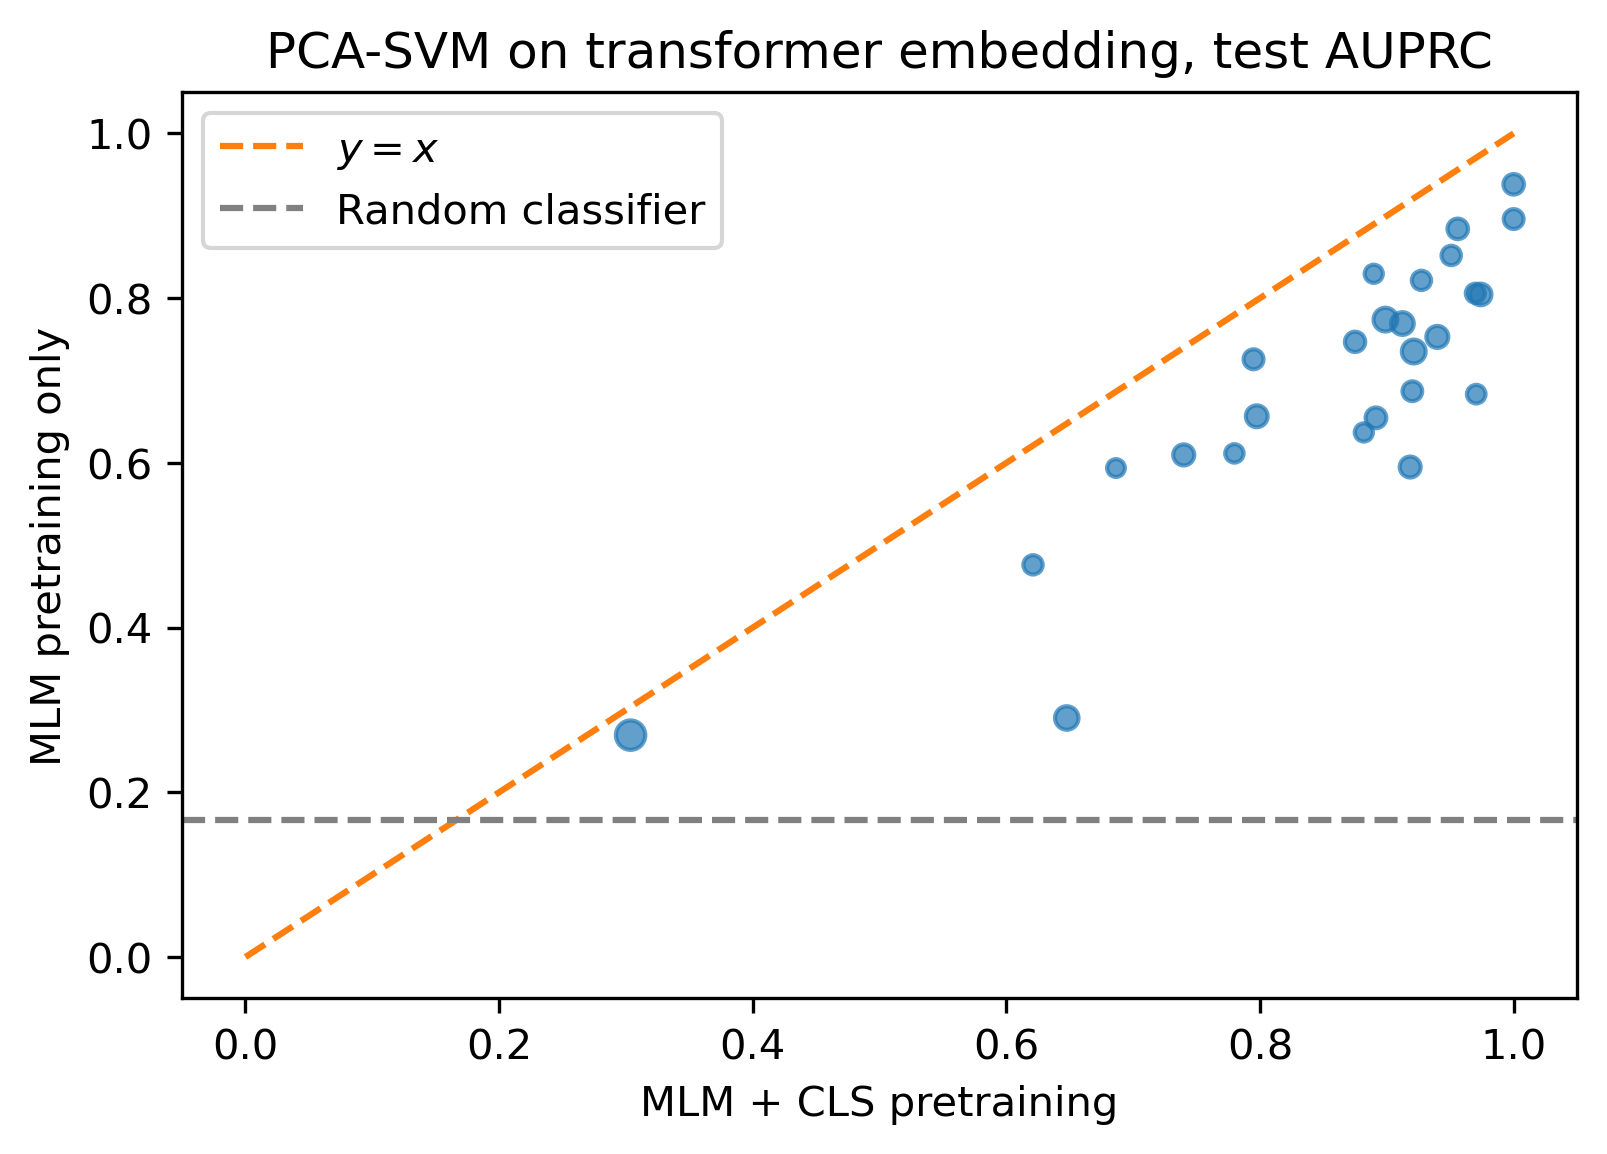

In [25]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    perf_pairs_df['MLM + CLS'],
    perf_pairs_df['MLM'],
    alpha=0.7,
    s=np.log(num_positive_examples) * 6,
)
ax.plot([0, 1], [0, 1], linestyle="--", color='tab:orange', label=r"$y=x$")
ax.axhline(1/(5+1), linestyle='--', color='grey', label="Random classifier")
ax.legend()
ax.set(
    xlabel="MLM + CLS pretraining",
    ylabel="MLM pretraining only",
    title="PCA-SVM on transformer embedding, test AUPRC"
)
fig.savefig(os.path.join(PLOT_DIR, "mlm_vs_mlmcls.pdf"), bbox_inches='tight')
fig.show()

In [26]:
stats.wilcoxon(
    perf_pairs_df['MLM'],
    perf_pairs_df['MLM + CLS'],
    alternative='less',
)

WilcoxonResult(statistic=0.0, pvalue=4.149049653178655e-06)

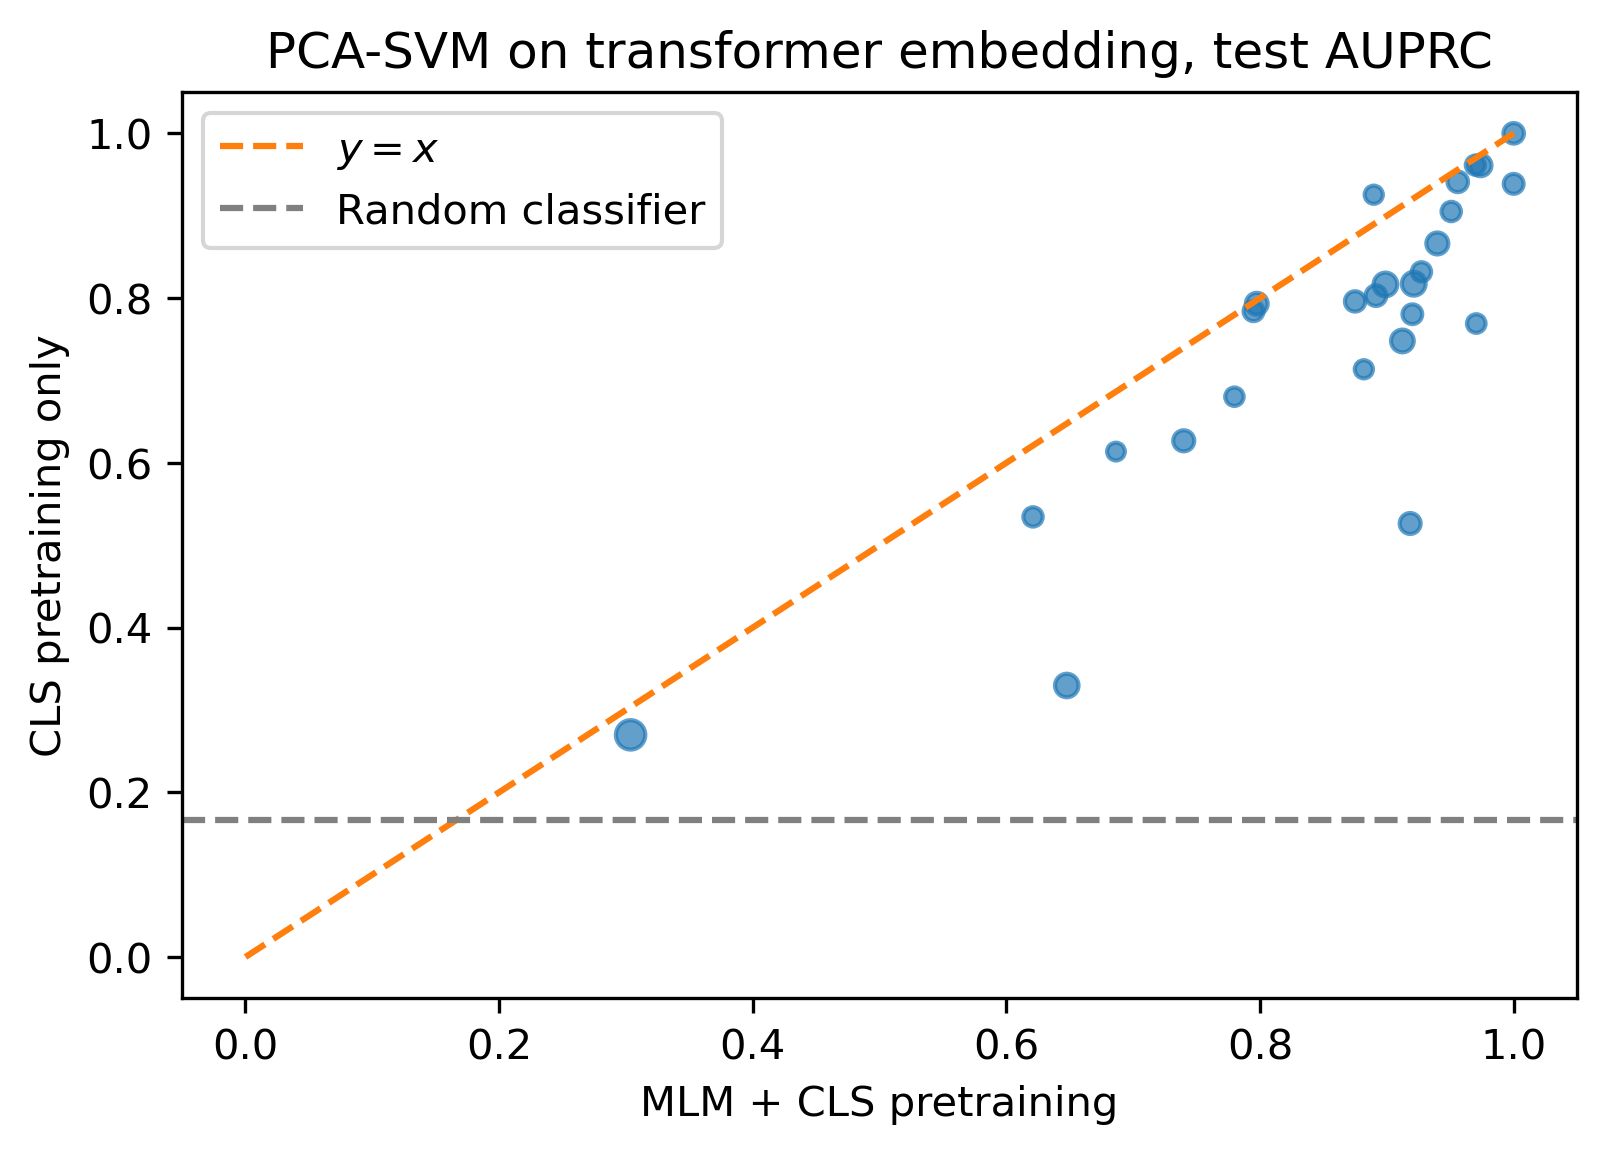

In [27]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    perf_pairs_df['MLM + CLS'],
    perf_pairs_df['CLS'],
    alpha=0.7,
    s=np.log(num_positive_examples) * 6,
)
ax.plot([0, 1], [0, 1], linestyle="--", color='tab:orange', label=r"$y=x$")
ax.axhline(1/(5+1), linestyle='--', color='grey', label="Random classifier")
ax.legend()
ax.set(
    xlabel="MLM + CLS pretraining",
    ylabel="CLS pretraining only",
    title="PCA-SVM on transformer embedding, test AUPRC"
)
fig.savefig(os.path.join(PLOT_DIR, "cls_vs_mlmcls.pdf"), bbox_inches='tight')
fig.show()

In [28]:
stats.wilcoxon(
    perf_pairs_df['MLM + CLS'],
    perf_pairs_df['CLS'],
    alternative='greater',
)

WilcoxonResult(statistic=318.0, pvalue=1.4319643696557219e-05)

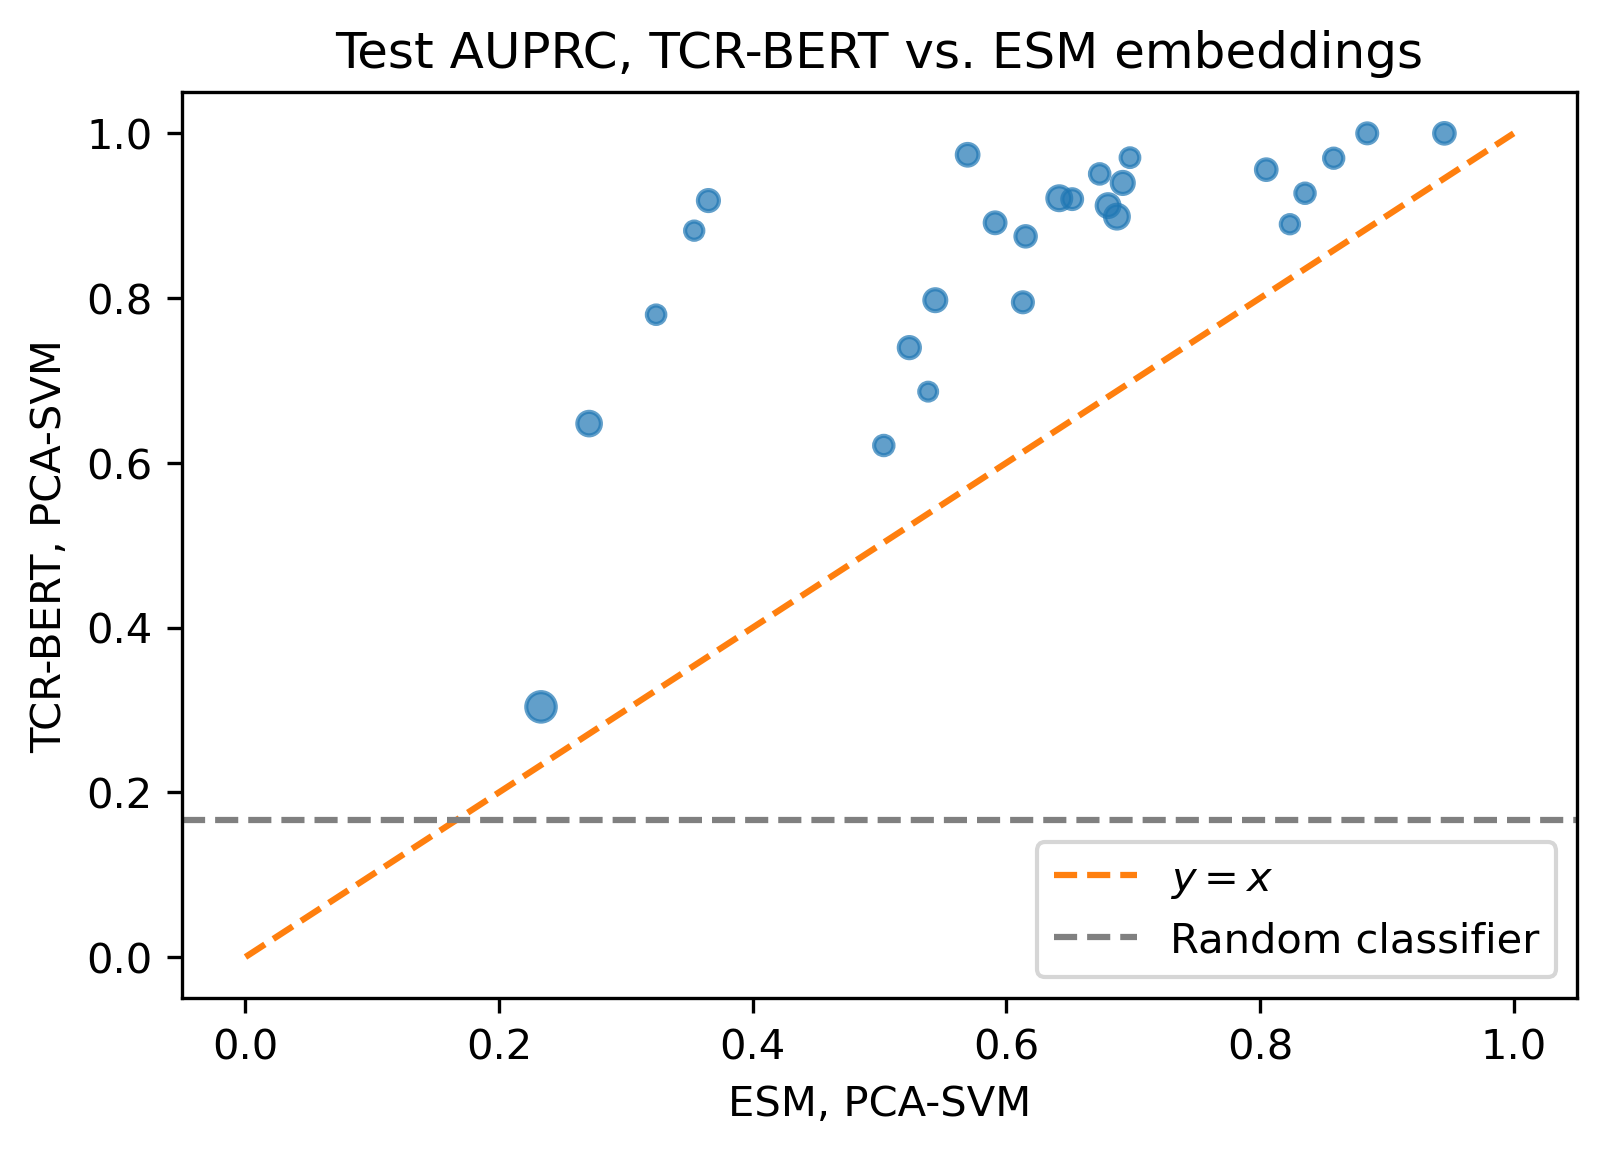

In [29]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    perf_pairs_df['ESM'],
    perf_pairs_df['MLM + CLS'],
    alpha=0.7,
    s=np.log(num_positive_examples) * 6,
)
ax.plot([0, 1], [0, 1], linestyle="--", color='tab:orange', label=r"$y=x$")
ax.axhline(1/(5+1), linestyle='--', color='grey', label="Random classifier")
ax.legend()
ax.set(
    xlabel="ESM, PCA-SVM",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. ESM embeddings"
)
fig.savefig(os.path.join(PLOT_DIR, "mlmcls_vs_esm.pdf"), bbox_inches='tight')
fig.show()

In [30]:
stats.wilcoxon(
    perf_pairs_df['MLM + CLS'],
    perf_pairs_df['ESM'],
    alternative='greater',
)

WilcoxonResult(statistic=351.0, pvalue=4.149049653178655e-06)

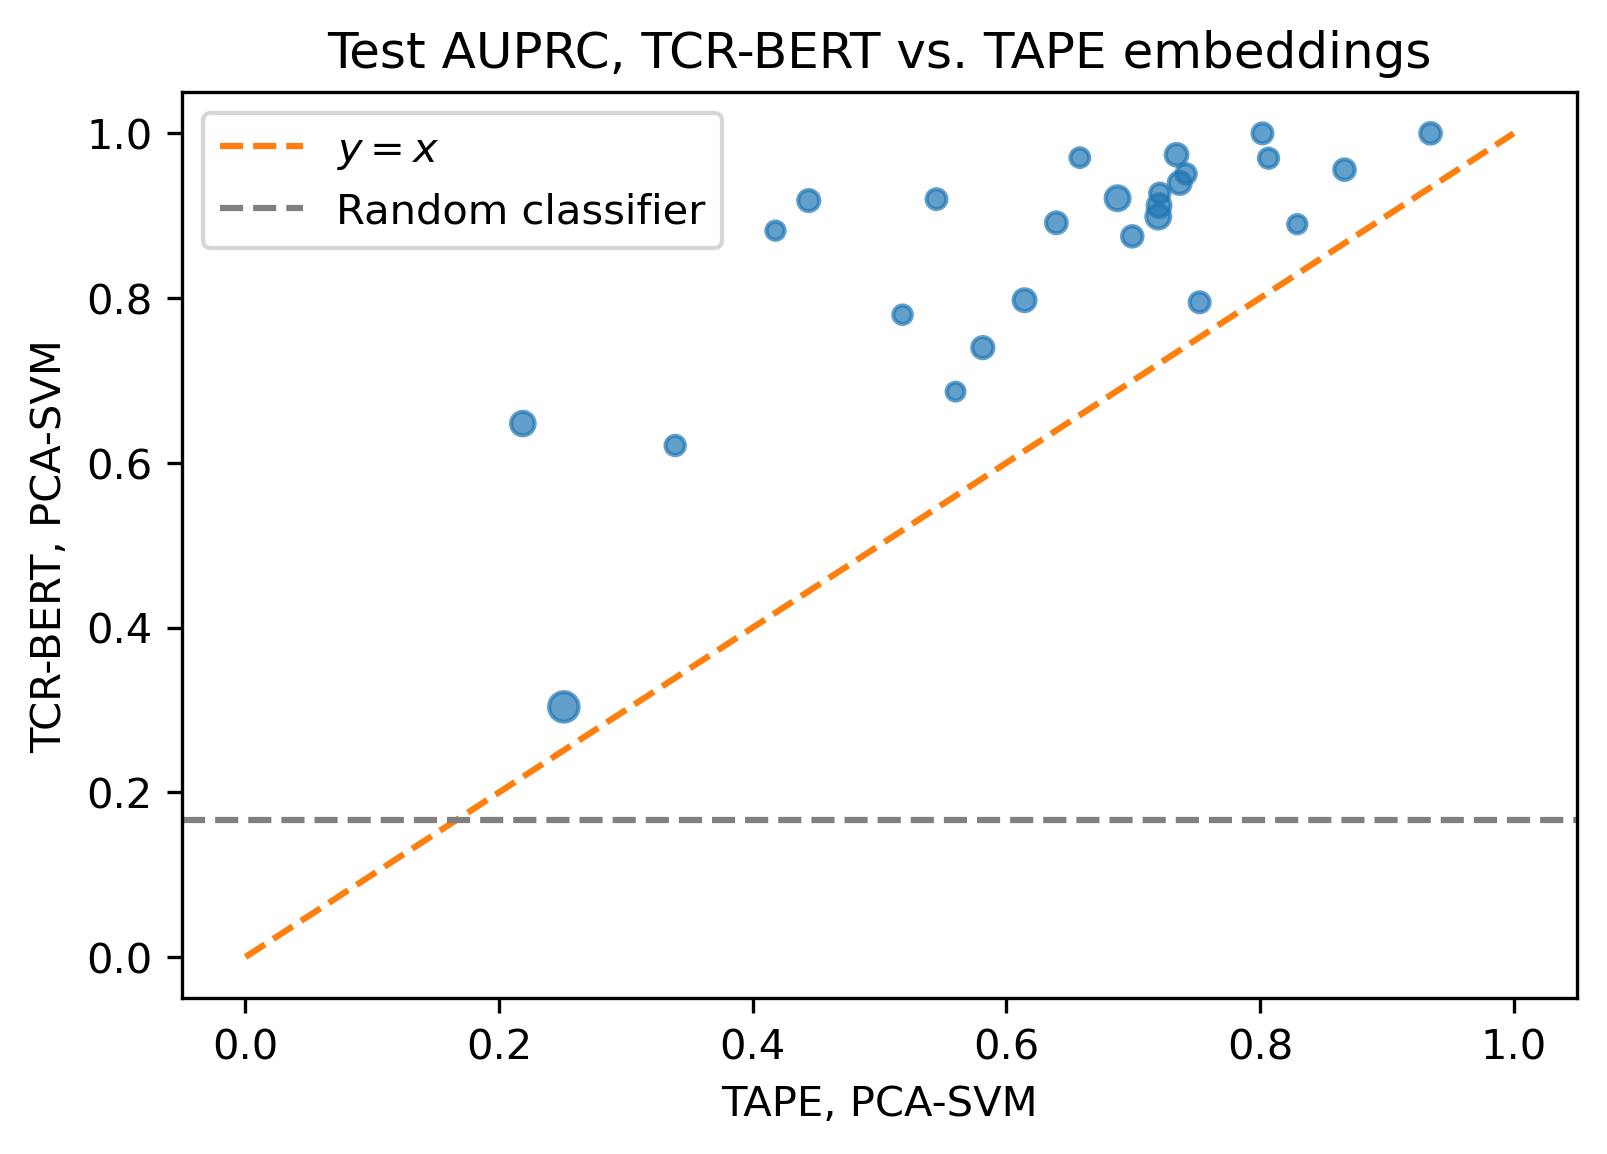

In [31]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    perf_pairs_df['TAPE'],
    perf_pairs_df['MLM + CLS'],
    alpha=0.7,
    s=np.log(num_positive_examples) * 6,
)
ax.plot([0, 1], [0, 1], linestyle="--", color='tab:orange', label=r"$y=x$")
ax.axhline(1/(5+1), linestyle='--', color='grey', label="Random classifier")
ax.legend()
ax.set(
    xlabel="TAPE, PCA-SVM",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. TAPE embeddings"
)
fig.savefig(os.path.join(PLOT_DIR, "mlmcls_vs_tape.pdf"), bbox_inches='tight')
fig.show()

In [32]:
stats.wilcoxon(
    perf_pairs_df['MLM + CLS'],
    perf_pairs_df['TAPE'],
    alternative='greater',
)

WilcoxonResult(statistic=351.0, pvalue=4.149049653178655e-06)

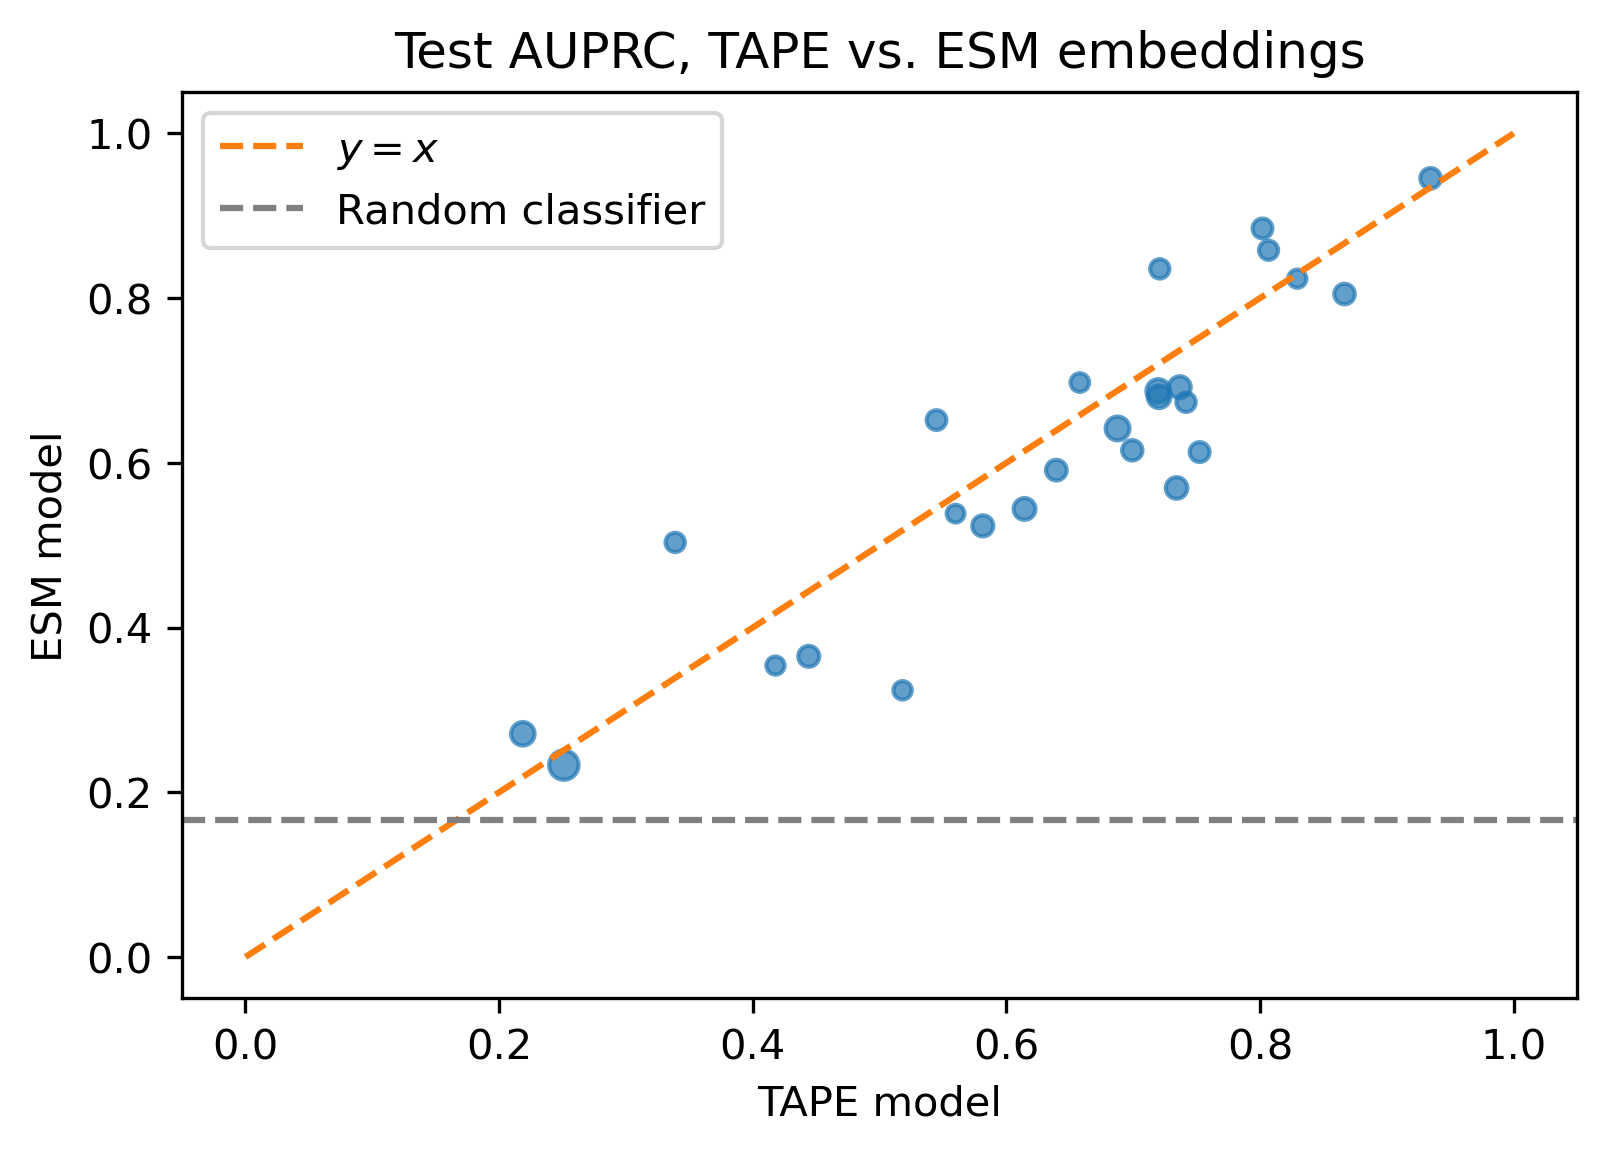

In [33]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    perf_pairs_df['TAPE'],
    perf_pairs_df['ESM'],
    alpha=0.7,
    s=np.log(num_positive_examples) * 6,
)
ax.plot([0, 1], [0, 1], linestyle="--", color='tab:orange', label=r"$y=x$")
ax.axhline(1/(5+1), linestyle='--', color='grey', label="Random classifier")
ax.legend()
ax.set(
    xlabel="TAPE model",
    ylabel="ESM model",
    title="Test AUPRC, TAPE vs. ESM embeddings"
)
fig.savefig(os.path.join(PLOT_DIR, "esm_vs_tape.pdf"), bbox_inches='tight')
fig.show()

In [34]:
# TAPE > ESM
stats.wilcoxon(
    perf_pairs_df['ESM'],
    perf_pairs_df['TAPE'],
    alternative='less',
)

WilcoxonResult(statistic=117.0, pvalue=0.0686684400873821)

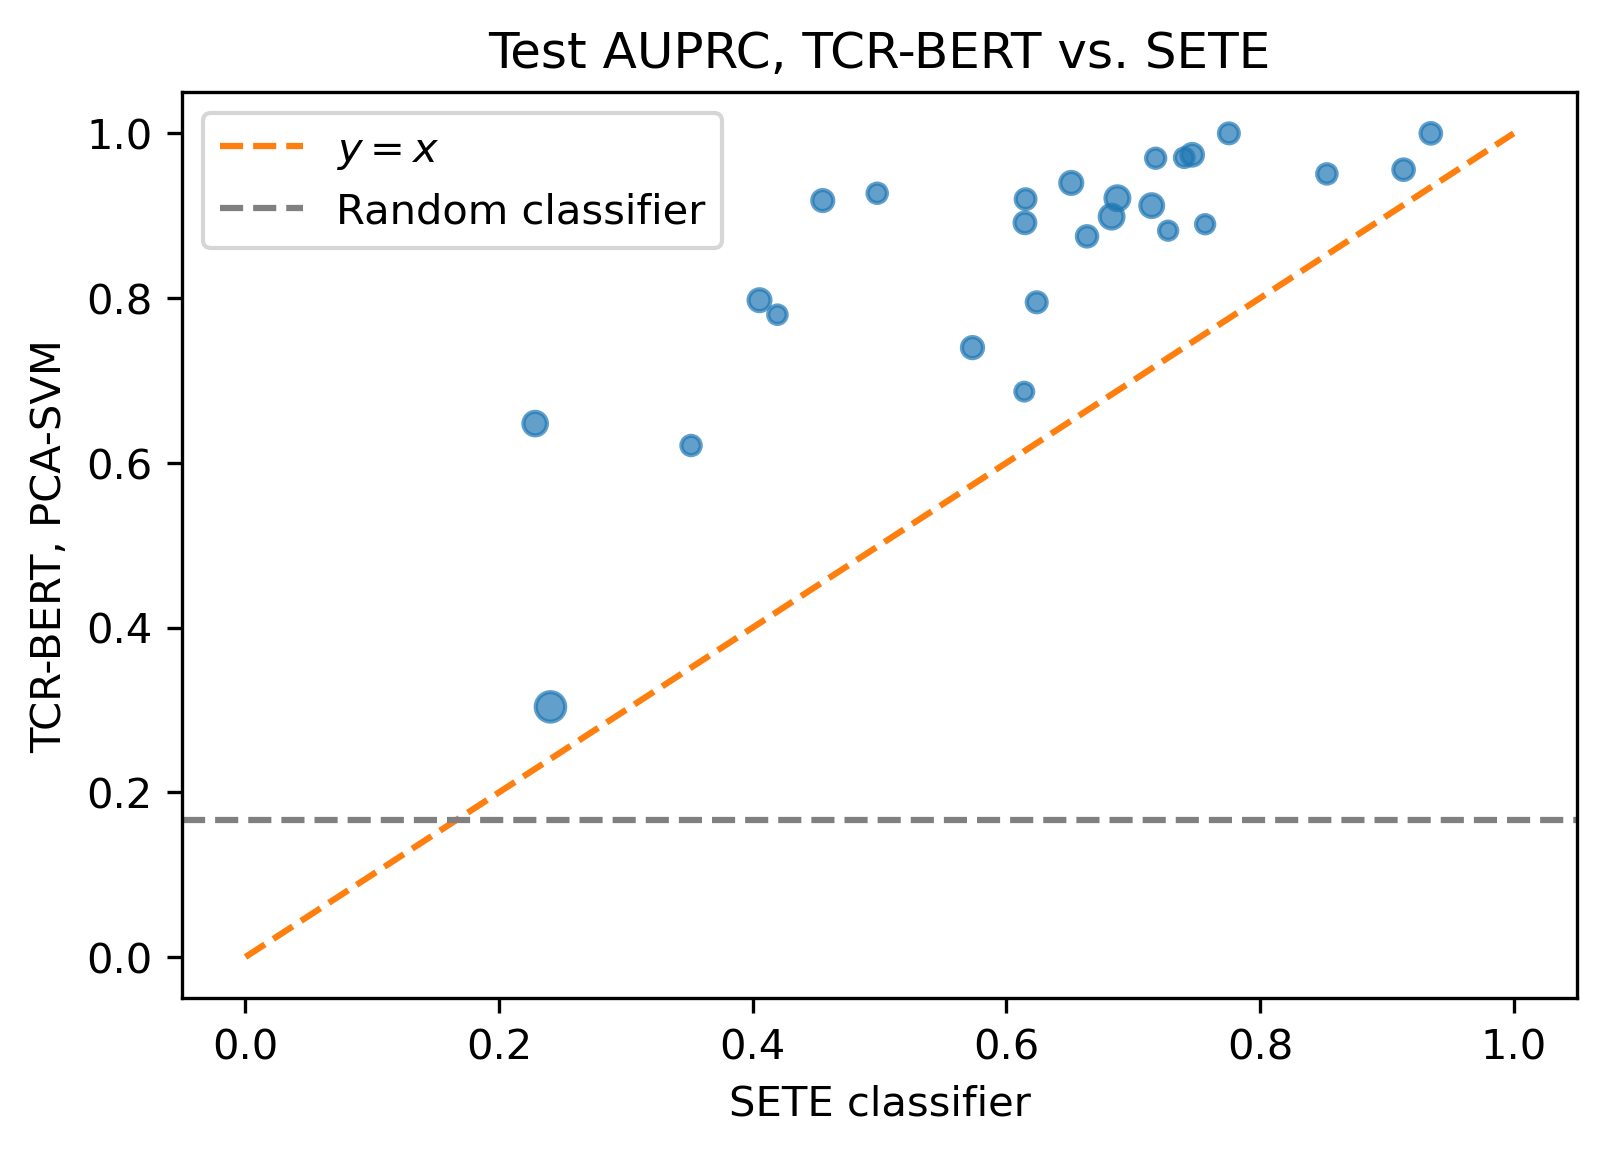

In [35]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    perf_pairs_df['SETE'],
    perf_pairs_df['MLM + CLS'],
    alpha=0.7,
    s=np.log(num_positive_examples) * 6,
)
ax.plot([0, 1], [0, 1], linestyle="--", color='tab:orange', label=r"$y=x$")
ax.axhline(1/(5+1), linestyle='--', color='grey', label="Random classifier")
ax.legend()
ax.set(
    xlabel="SETE classifier",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. SETE"
)
fig.savefig(os.path.join(PLOT_DIR, "mlmcls_vs_sete.pdf"), bbox_inches='tight')
fig.show()

In [37]:
stats.wilcoxon(
    perf_pairs_df['MLM + CLS'],
    perf_pairs_df['SETE'],
    alternative='greater',
)

WilcoxonResult(statistic=351.0, pvalue=4.149049653178655e-06)

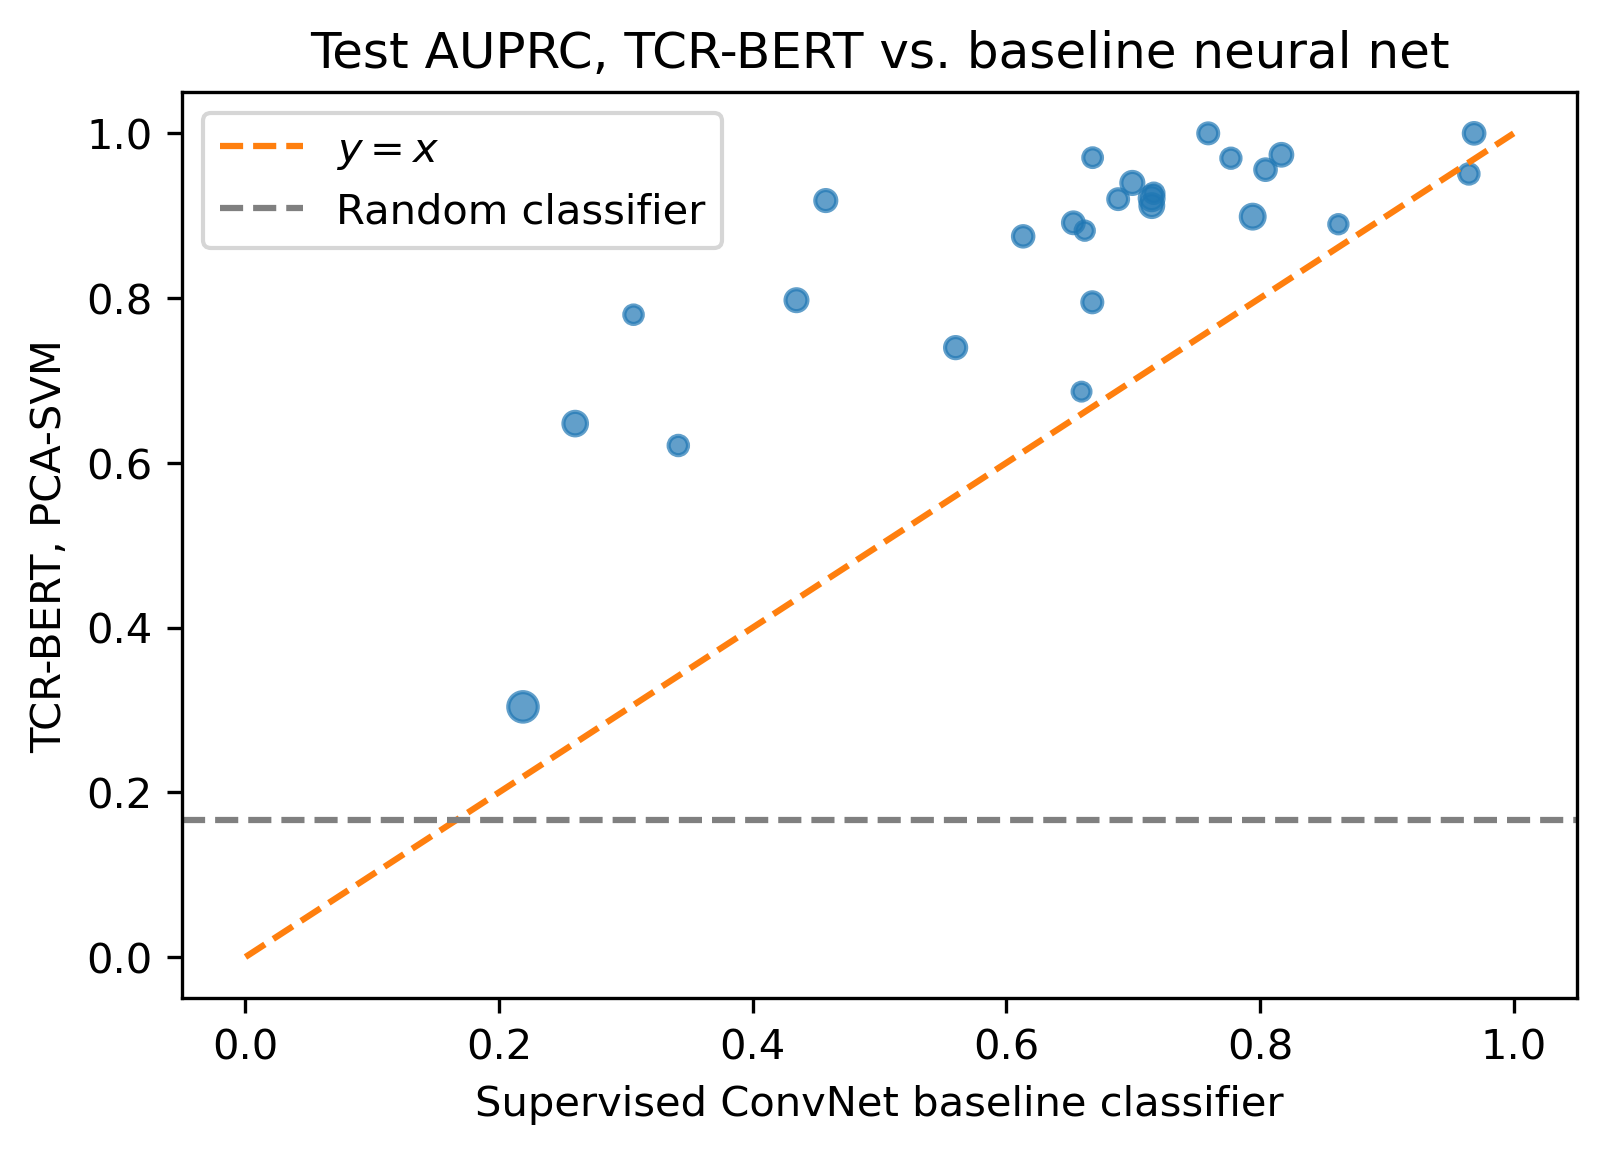

In [38]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    perf_pairs_df['ConvNet'],
    perf_pairs_df['MLM + CLS'],
    alpha=0.7,
    s=np.log(num_positive_examples) * 6,
)
ax.plot([0, 1], [0, 1], linestyle="--", color='tab:orange', label=r"$y=x$")
ax.axhline(1/(5+1), linestyle='--', color='grey', label="Random classifier")
ax.legend()
ax.set(
    xlabel="Supervised ConvNet baseline classifier",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. baseline neural net",
)
fig.savefig(
    os.path.join(PLOT_DIR, "mlmcls_vs_convnet.pdf"), bbox_inches='tight'
)
fig.show()

In [39]:
stats.wilcoxon(
    perf_pairs_df['MLM + CLS'],
    perf_pairs_df['ConvNet'],
    alternative='greater',
)

WilcoxonResult(statistic=350.0, pvalue=4.669298085524511e-06)